In [1]:
import numpy as np
import numpy.matlib as mt
import h5py
import math 
from ephysvibe.structures.neuron_data import NeuronData
from ephysvibe.trials import align_trials
from ephysvibe.task import task_constants

from sklearn import metrics
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from scipy import signal,stats

import os 
from matplotlib import cm
from matplotlib import pyplot as plt
import glob
from pathlib import Path
import pickle

from joblib import Parallel, delayed
from tqdm import tqdm
from itertools import permutations
seed = 2023


In [2]:
def scale_p(x, out_range=(-1, 1)):
    if np.sum(x>1) >0:
        return
    domain = 0, 1
    y = (x - (domain[1] + domain[0]) / 2) / (domain[1] - domain[0])
    return y * (out_range[1] - out_range[0]) + (out_range[1] + out_range[0]) / 2

In [3]:
def compute_roc_auc(group1,group2):
    rng = np.random.default_rng(seed=seed)
    roc_score = []
    p = []
    for n_win in np.arange(group1.shape[1]):
        g1 = group1[:,n_win]
        g2 = group2[:,n_win]

        # Wilcoxon rank-sum 
        p.append(stats.ranksums(g1, g2)[1])#stats.ttest_ind

        thresholds = np.unique(np.concatenate([g1,g2]))

        y_g1, y_g2 = np.ones(len(g1)),np.zeros(len(g2))
        score=0.5
        fpr,tpr=[],[]
        for threshold in thresholds:
            g1_y_pred,g2_y_pred = np.zeros(len(g1)),np.zeros(len(g2))
            g1_mask,g2_mask = g1>=threshold,g2>=threshold
            g1_y_pred[g1_mask],g2_y_pred[g2_mask] = 1,1
            tp = sum(np.logical_and(y_g1==1,g1_y_pred==1))
            fn = sum(np.logical_and(y_g1==1,g1_y_pred==0))
            tpr.append(tp/ (tp+fn) )
            fp = sum(np.logical_and(y_g2==0,g2_y_pred==1))
            tn = sum(np.logical_and(y_g2==0,g2_y_pred==0))
            fpr.append(fp/ (fp+tn) )
        if len(fpr) > 1:
            fpr,tpr=np.array(fpr),np.array(tpr)
                      
            score = metrics.auc(fpr[fpr.argsort()],tpr[fpr.argsort()])
        roc_score.append(score)
        
    roc_score = np.array(roc_score)
    p=np.array(p)
    
    roc_score = scale_p(np.round(roc_score,2),out_range=[-1,1])
    
    return roc_score, p


In [4]:
def match_vis_plot(time,data,title, c1_match, c2_match, c1_nomatch, c2_nomatch, rt, min, max, ax):
    if any(c1_match):
        match_vis_plot=ax.plot(time, np.mean(data[c1_match, :650], axis=0)*1000, color='r', linewidth=2)

    if any(c2_match):
        match_vis_plot=ax.plot(time, np.mean(data[c2_match, :650], axis=0)*1000, color='b', linewidth=2)

    if any(c1_nomatch):
        match_vis_plot=ax.plot(time, np.mean(data[c1_nomatch, :650], axis=0)*1000, color='r', linestyle=(5, (5,2)), linewidth=2)
    if any(c2_nomatch):
        match_vis_plot=ax.plot(time, np.mean(data[c2_nomatch, :650], axis=0)*1000, color='b', linestyle=(5, (5,2)), linewidth=2)

    match_vis_plot=ax.plot([rt, rt], [min,max], 'k', linewidth=2)
    match_vis_plot=ax.plot([0,0], [min,max], color=[.5,.5,.5], linewidth=2)


    match_vis_plot=ax.spines['top'].set_visible(False)
    match_vis_plot=ax.spines['right'].set_visible(False)

    
    match_vis_plot=ax.tick_params(direction="in")
    match_vis_plot=ax.set_ylim([min, max])
    match_vis_plot=ax.set_xlim([-100, 500])
    match_vis_plot=ax.set_title(title)

    return match_vis_plot

In [5]:
def match_vis_roc_plot(time, r_match, r_vis, p_match, p_vis, rt, min, max, ax):
    if any(r_match):
        match_vis_plot=ax.plot(time, r_match[:650], color='k', linewidth=2)
    if any(r_vis):
        match_vis_plot=ax.plot(time, r_vis[:650], color=[.5,.5,.5], linewidth=2)
    
    match_vis_plot=ax.plot([rt, rt], [min,max], 'k', linewidth=2)
    match_vis_plot=ax.plot([0,0], [min,max], color=[.5,.5,.5], linewidth=2)


    if any(p_vis):
        if any(p_vis<0.01):
            match_vis_plot=ax.plot(time[np.where(p_vis[:600]<0.01)[0]], np.zeros(np.sum(p_vis[:600]<0.01))-0.7, color=[.5,.5,.5],marker='*')
    if any(p_match):
        if any(p_match<0.01):
            match_vis_plot=ax.plot(time[np.where(p_match[:600]<0.01)[0]], np.zeros(np.sum(p_match[:600]<0.01))-0.9, color='k',marker='*')

    match_vis_plot=ax.spines['top'].set_visible(False)
    match_vis_plot=ax.spines['right'].set_visible(False)

    
    match_vis_plot=ax.tick_params(direction="in")
    match_vis_plot=ax.set_ylim([min, max])
    match_vis_plot=ax.set_xlim([-100, 500])
    # match_vis_plot=ax.set_title(title)

    return match_vis_plot

In [6]:
with open('C:/Users/ibos.g/Documents/Data/INT-Marseille/OpenEphys/Riesling/averaged_structures/test/lip_test_avg', 'rb') as handle:
    test_lip_avg = pickle.load(handle)


with open('C:/Users/ibos.g/Documents/Data/INT-Marseille/OpenEphys/Riesling/averaged_structures/test/lip_test_cond', 'rb') as handle:
    test_lip_cond = pickle.load(handle)

In [7]:
def ocm(test_data):

# test_data=test_lip_avg[0]

# basic conditions
    s_in_o1c1_t_o1c1= np.where(np.logical_and(np.logical_and(test_data['sample id']==11, test_data['test id']==11), test_data['sample pos']==1))[0]
    s_in_o1c5_t_o1c1= np.where(np.logical_and(np.logical_and(test_data['sample id']==15, test_data['test id']==11), test_data['sample pos']==1))[0]
    s_in_o5c1_t_o1c1= np.where(np.logical_and(np.logical_and(test_data['sample id']==51, test_data['test id']==11), test_data['sample pos']==1))[0]
    s_in_o5c5_t_o1c1= np.where(np.logical_and(np.logical_and(test_data['sample id']==55, test_data['test id']==11), test_data['sample pos']==1))[0]

    s_in_o1c1_t_o1c5= np.where(np.logical_and(np.logical_and(test_data['sample id']==11, test_data['test id']==15), test_data['sample pos']==1))[0]
    s_in_o1c5_t_o1c5= np.where(np.logical_and(np.logical_and(test_data['sample id']==15, test_data['test id']==15), test_data['sample pos']==1))[0]
    s_in_o5c1_t_o1c5= np.where(np.logical_and(np.logical_and(test_data['sample id']==51, test_data['test id']==15), test_data['sample pos']==1))[0]
    s_in_o5c5_t_o1c5= np.where(np.logical_and(np.logical_and(test_data['sample id']==55, test_data['test id']==15), test_data['sample pos']==1))[0]

    s_in_o1c1_t_o5c1= np.where(np.logical_and(np.logical_and(test_data['sample id']==11, test_data['test id']==51), test_data['sample pos']==1))[0]
    s_in_o1c5_t_o5c1= np.where(np.logical_and(np.logical_and(test_data['sample id']==15, test_data['test id']==51), test_data['sample pos']==1))[0]
    s_in_o5c1_t_o5c1= np.where(np.logical_and(np.logical_and(test_data['sample id']==51, test_data['test id']==51), test_data['sample pos']==1))[0]
    s_in_o5c5_t_o5c1= np.where(np.logical_and(np.logical_and(test_data['sample id']==55, test_data['test id']==51), test_data['sample pos']==1))[0]

    s_in_o1c1_t_o5c5= np.where(np.logical_and(np.logical_and(test_data['sample id']==11, test_data['test id']==55), test_data['sample pos']==1))[0]
    s_in_o1c5_t_o5c5= np.where(np.logical_and(np.logical_and(test_data['sample id']==15, test_data['test id']==55), test_data['sample pos']==1))[0]
    s_in_o5c1_t_o5c5= np.where(np.logical_and(np.logical_and(test_data['sample id']==51, test_data['test id']==55), test_data['sample pos']==1))[0]
    s_in_o5c5_t_o5c5= np.where(np.logical_and(np.logical_and(test_data['sample id']==55, test_data['test id']==55), test_data['sample pos']==1))[0]

    s_out_o1c1_t_o1c1= np.where(np.logical_and(np.logical_and(test_data['sample id']==11, test_data['test id']==11), test_data['sample pos']==-1))[0]
    s_out_o1c5_t_o1c1= np.where(np.logical_and(np.logical_and(test_data['sample id']==15, test_data['test id']==11), test_data['sample pos']==-1))[0]
    s_out_o5c1_t_o1c1= np.where(np.logical_and(np.logical_and(test_data['sample id']==51, test_data['test id']==11), test_data['sample pos']==-1))[0]
    s_out_o5c5_t_o1c1= np.where(np.logical_and(np.logical_and(test_data['sample id']==55, test_data['test id']==11), test_data['sample pos']==-1))[0]

    s_out_o1c1_t_o1c5= np.where(np.logical_and(np.logical_and(test_data['sample id']==11, test_data['test id']==15), test_data['sample pos']==-1))[0]
    s_out_o1c5_t_o1c5= np.where(np.logical_and(np.logical_and(test_data['sample id']==15, test_data['test id']==15), test_data['sample pos']==-1))[0]
    s_out_o5c1_t_o1c5= np.where(np.logical_and(np.logical_and(test_data['sample id']==51, test_data['test id']==15), test_data['sample pos']==-1))[0]
    s_out_o5c5_t_o1c5= np.where(np.logical_and(np.logical_and(test_data['sample id']==55, test_data['test id']==15), test_data['sample pos']==-1))[0]

    s_out_o1c1_t_o5c1= np.where(np.logical_and(np.logical_and(test_data['sample id']==11, test_data['test id']==51), test_data['sample pos']==-1))[0]
    s_out_o1c5_t_o5c1= np.where(np.logical_and(np.logical_and(test_data['sample id']==15, test_data['test id']==51), test_data['sample pos']==-1))[0]
    s_out_o5c1_t_o5c1= np.where(np.logical_and(np.logical_and(test_data['sample id']==51, test_data['test id']==51), test_data['sample pos']==-1))[0]
    s_out_o5c5_t_o5c1= np.where(np.logical_and(np.logical_and(test_data['sample id']==55, test_data['test id']==51), test_data['sample pos']==-1))[0]

    s_out_o1c1_t_o5c5= np.where(np.logical_and(np.logical_and(test_data['sample id']==11, test_data['test id']==55), test_data['sample pos']==-1))[0]
    s_out_o1c5_t_o5c5= np.where(np.logical_and(np.logical_and(test_data['sample id']==15, test_data['test id']==55), test_data['sample pos']==-1))[0]
    s_out_o5c1_t_o5c5= np.where(np.logical_and(np.logical_and(test_data['sample id']==51, test_data['test id']==55), test_data['sample pos']==-1))[0]
    s_out_o5c5_t_o5c5= np.where(np.logical_and(np.logical_and(test_data['sample id']==55, test_data['test id']==55), test_data['sample pos']==-1))[0]

# comparing o1c1 to o5c5 and o1c5 to o5c1

#IN
    s_in_1155_t_11 =   np.concatenate([s_in_o1c1_t_o1c1, s_in_o5c5_t_o1c1])
    s_in_1155_t_55 =   np.concatenate([s_in_o1c1_t_o5c5, s_in_o5c5_t_o5c5])

    s_in_1155_t_match  =   np.concatenate([s_in_o1c1_t_o1c1, s_in_o5c5_t_o5c5])
    s_in_1155_t_nomatch=   np.concatenate([s_in_o5c5_t_o1c1,  s_in_o1c1_t_o5c5])

    s_in_1551_t_15  =   np.concatenate([s_in_o1c5_t_o1c5, s_in_o5c1_t_o1c5])
    s_in_1551_t_51  =   np.concatenate([s_in_o1c5_t_o5c1, s_in_o5c1_t_o5c1])

    s_in_1551_t_match  =   np.concatenate([s_in_o1c5_t_o1c5, s_in_o5c1_t_o5c1])
    s_in_1551_t_nomatch=   np.concatenate([s_in_o5c1_t_o1c5,  s_in_o1c5_t_o5c1])

    # OUT
    s_out_1155_t_11 =   np.concatenate([s_out_o1c1_t_o1c1, s_out_o5c5_t_o1c1])
    s_out_1155_t_55 =   np.concatenate([s_out_o1c1_t_o5c5, s_out_o5c5_t_o5c5])

    s_out_1155_t_match  =   np.concatenate([s_out_o1c1_t_o1c1, s_out_o5c5_t_o5c5])
    s_out_1155_t_nomatch=   np.concatenate([s_out_o5c5_t_o1c1,  s_out_o1c1_t_o5c5])

    s_out_1551_t_15     =   np.concatenate([s_out_o1c5_t_o1c5, s_out_o5c1_t_o1c5])
    s_out_1551_t_51     =   np.concatenate([s_out_o1c5_t_o5c1, s_out_o5c1_t_o5c1])

    s_out_1551_t_match  =   np.concatenate([s_out_o1c5_t_o1c5, s_out_o5c1_t_o5c1])
    s_out_1551_t_nomatch=   np.concatenate([s_out_o5c1_t_o1c5,  s_out_o1c5_t_o5c1])

    roc_vis_1551_av_out, p_vis_1551_av_out        =   compute_roc_auc(test_data['averaged data'][s_out_1551_t_15, :], 
                                                                    test_data['averaged data'][s_out_1551_t_51, :])
    roc_match_1551_av_out, p_match_1551_av_out    =   compute_roc_auc(test_data['averaged data'][s_out_1551_t_match, :], 
                                                                    test_data['averaged data'][s_out_1551_t_nomatch, :])

# By orientation and color

    s_in_o1_t_o1  =   np.concatenate([s_in_o1c1_t_o1c1, s_in_o1c1_t_o1c5, s_in_o1c5_t_o1c1, s_in_o1c5_t_o1c5])
    s_in_o1_t_o5  =   np.concatenate([s_in_o1c1_t_o5c1, s_in_o1c1_t_o5c5, s_in_o1c5_t_o5c1, s_in_o1c5_t_o5c5])
    s_in_o5_t_o1  =   np.concatenate([s_in_o5c1_t_o1c1, s_in_o5c1_t_o1c5, s_in_o5c5_t_o1c1, s_in_o5c5_t_o1c5])
    s_in_o5_t_o5  =   np.concatenate([s_in_o5c1_t_o5c1, s_in_o5c1_t_o5c5, s_in_o5c5_t_o5c1, s_in_o5c5_t_o5c5])

    s_in_c1_t_c1  =   np.concatenate([s_in_o1c1_t_o1c1, s_in_o1c1_t_o5c1, s_in_o5c1_t_o1c1, s_in_o5c1_t_o5c1])
    s_in_c1_t_c5  =   np.concatenate([s_in_o1c1_t_o1c5, s_in_o1c1_t_o5c5, s_in_o5c1_t_o1c5, s_in_o5c1_t_o5c5])
    s_in_c5_t_c1  =   np.concatenate([s_in_o1c5_t_o1c1, s_in_o1c5_t_o5c1, s_in_o5c5_t_o1c1, s_in_o5c5_t_o5c1])
    s_in_c5_t_c5  =   np.concatenate([s_in_o1c5_t_o1c5, s_in_o5c5_t_o5c5, s_in_o1c5_t_o1c5, s_in_o5c5_t_o5c5])

    s_in_match      =   np.concatenate([s_in_o1c1_t_o1c1, s_in_o1c5_t_o1c5, s_in_o5c1_t_o5c1, s_in_o5c1_t_o5c5])
    s_in_nomatch    =   np.concatenate([s_in_o1c1_t_o1c5, s_in_o1c1_t_o5c1,s_in_o1c1_t_o5c5,
                                        s_in_o1c5_t_o1c1, s_in_o1c5_t_o5c1,s_in_o1c5_t_o5c5,
                                        s_in_o5c1_t_o1c1, s_in_o5c1_t_o1c5,s_in_o5c1_t_o5c5,
                                        s_in_o5c5_t_o1c1, s_in_o5c5_t_o1c5,s_in_o5c5_t_o5c1])

    s_out_o1_t_o1  =   np.concatenate([s_out_o1c1_t_o1c1, s_out_o1c1_t_o1c5, s_out_o1c5_t_o1c1, s_out_o1c5_t_o1c5])
    s_out_o1_t_o5  =   np.concatenate([s_out_o1c1_t_o5c1, s_out_o1c1_t_o5c5, s_out_o1c5_t_o5c1, s_out_o1c5_t_o5c5])
    s_out_o5_t_o1  =   np.concatenate([s_out_o5c1_t_o1c1, s_out_o5c1_t_o1c5, s_out_o5c5_t_o1c1, s_out_o5c5_t_o1c5])
    s_out_o5_t_o5  =   np.concatenate([s_out_o5c1_t_o5c1, s_out_o5c1_t_o5c5, s_out_o5c5_t_o5c1, s_out_o5c5_t_o5c5])

    s_out_c1_t_c1  =   np.concatenate([s_out_o1c1_t_o1c1, s_out_o1c1_t_o5c1, s_out_o5c1_t_o1c1, s_out_o5c1_t_o5c1])
    s_out_c1_t_c5  =   np.concatenate([s_out_o1c1_t_o1c5, s_out_o1c1_t_o5c5, s_out_o5c1_t_o1c5, s_out_o5c1_t_o5c5])
    s_out_c5_t_c1  =   np.concatenate([s_out_o1c5_t_o1c1, s_out_o1c5_t_o5c1, s_out_o5c5_t_o1c1, s_out_o5c5_t_o5c1])
    s_out_c5_t_c5  =   np.concatenate([s_out_o1c5_t_o1c5, s_out_o5c5_t_o5c5, s_out_o1c5_t_o1c5, s_out_o5c5_t_o5c5])

    s_out_match      =   np.concatenate([s_out_o1c1_t_o1c1, s_out_o1c5_t_o1c5, s_out_o5c1_t_o5c1, s_out_o5c1_t_o5c5])
    s_out_nomatch    =   np.concatenate([s_out_o1c1_t_o1c5, s_out_o1c1_t_o5c1,s_out_o1c1_t_o5c5,
                                        s_out_o1c5_t_o1c1, s_out_o1c5_t_o5c1,s_out_o1c5_t_o5c5,
                                        s_out_o5c1_t_o1c1, s_out_o5c1_t_o1c5,s_out_o5c1_t_o5c5,
                                        s_out_o5c5_t_o1c1, s_out_o5c5_t_o1c5,s_out_o5c5_t_o5c1])

    
    ma=     np.max(np.concatenate([np.mean(test_data['averaged data'][s_in_o1c1_t_o1c1, :600], axis=0),
                                np.mean(test_data['averaged data'][s_in_o5c5_t_o5c5, :600], axis=0),
                                np.mean(test_data['averaged data'][np.concatenate([s_in_o1c5_t_o1c1, s_in_o5c1_t_o1c1, s_in_o5c5_t_o1c1]),:600], axis=0),
                                np.mean(test_data['averaged data'][np.concatenate([s_in_o1c1_t_o5c5, s_in_o1c5_t_o5c5, s_in_o5c1_t_o5c5]),:600], axis=0),
                                np.mean(test_data['averaged data'][s_in_o5c1_t_o5c1, :600], axis=0),
                                np.mean(test_data['averaged data'][s_in_o1c5_t_o1c5, :600], axis=0),
                                np.mean(test_data['averaged data'][np.concatenate([s_in_o1c1_t_o1c5, s_in_o5c1_t_o1c5, s_in_o5c5_t_o1c5]),:600], axis=0),
                                np.mean(test_data['averaged data'][np.concatenate([s_in_o1c1_t_o5c1, s_in_o1c5_t_o5c1, s_in_o5c5_t_o5c1]),:600], axis=0),
                                np.mean(test_data['averaged data'][s_out_o1c1_t_o1c1, :600], axis=0),
                                np.mean(test_data['averaged data'][s_out_o5c5_t_o5c5, :600], axis=0),
                                np.mean(test_data['averaged data'][np.concatenate([s_out_o1c5_t_o1c1, s_out_o5c1_t_o1c1, s_out_o5c5_t_o1c1]),:600], axis=0),
                                np.mean(test_data['averaged data'][np.concatenate([s_out_o1c1_t_o5c5, s_out_o1c5_t_o5c5, s_out_o5c1_t_o5c5]),:600], axis=0),
                                np.mean(test_data['averaged data'][s_out_o5c1_t_o5c1, :600], axis=0),
                                np.mean(test_data['averaged data'][s_out_o1c5_t_o1c5, :600], axis=0),
                                np.mean(test_data['averaged data'][np.concatenate([s_out_o1c1_t_o1c5, s_out_o5c1_t_o1c5, s_out_o5c5_t_o1c5]),:600], axis=0),
                                np.mean(test_data['averaged data'][np.concatenate([s_out_o1c1_t_o5c1, s_out_o1c5_t_o5c1, s_out_o5c5_t_o5c1]),:600], axis=0)]))
    
    roc_vis_1155_av_in, p_vis_1155_av_in        =   compute_roc_auc(test_data['averaged data'][s_in_1155_t_11, :], 
                                                                    test_data['averaged data'][s_in_1155_t_55, :])
    roc_match_1155_av_in, p_match_1155_av_in    =   compute_roc_auc(test_data['averaged data'][s_in_1155_t_match, :], 
                                                                    test_data['averaged data'][s_in_1155_t_nomatch, :])
    roc_vis_1551_av_in, p_vis_1551_av_in        =   compute_roc_auc(test_data['averaged data'][s_in_1551_t_15, :], 
                                                                    test_data['averaged data'][s_in_1551_t_51, :])
    roc_match_1551_av_in, p_match_1551_av_in    =   compute_roc_auc(test_data['averaged data'][s_in_1551_t_match, :], 
                                                                    test_data['averaged data'][s_in_1551_t_nomatch, :])
    roc_vis_1155_av_out, p_vis_1155_av_out        =   compute_roc_auc(test_data['averaged data'][s_out_1155_t_11, :], 
                                                                    test_data['averaged data'][s_out_1155_t_55, :])
    roc_match_1155_av_out, p_match_1155_av_out    =   compute_roc_auc(test_data['averaged data'][s_out_1155_t_match, :], 
                                                                    test_data['averaged data'][s_out_1155_t_nomatch, :])
    roc_vis_ori_av_in, p_vis_ori_av_in  =   compute_roc_auc(test_data['averaged data'][np.concatenate([s_in_o1_t_o1, s_in_o5_t_o1]), :], 
                                                            test_data['averaged data'][np.concatenate([s_in_o1_t_o5, s_in_o5_t_o5]), :])
    roc_match_ori_av_in, p_match_ori_av_in  =   compute_roc_auc(test_data['averaged data'][np.concatenate([s_in_o1_t_o1, s_in_o5_t_o5]), :], 
                                                            test_data['averaged data'][np.concatenate([s_in_o1_t_o5, s_in_o5_t_o1]), :])
    roc_vis_col_av_in, p_vis_col_av_in  =   compute_roc_auc(test_data['averaged data'][np.concatenate([s_in_c1_t_c1, s_in_c5_t_c5]), :], 
                                                            test_data['averaged data'][np.concatenate([s_in_c1_t_c5, s_in_c5_t_c5]), :])
    roc_match_col_av_in, p_match_col_av_in  =   compute_roc_auc(test_data['averaged data'][np.concatenate([s_in_c1_t_c1, s_in_c5_t_c5]), :], 
                                                            test_data['averaged data'][np.concatenate([s_in_c1_t_c5, s_in_c5_t_c1]), :])
    roc_vis_ori_av_out, p_vis_ori_av_out  =   compute_roc_auc(test_data['averaged data'][np.concatenate([s_out_o1_t_o1, s_out_o5_t_o1]), :], 
                                                            test_data['averaged data'][np.concatenate([s_out_o1_t_o5, s_out_o5_t_o5]), :])
    roc_match_ori_av_out, p_match_ori_av_out  =   compute_roc_auc(test_data['averaged data'][np.concatenate([s_out_o1_t_o1, s_out_o5_t_o5]), :], 
                                                            test_data['averaged data'][np.concatenate([s_out_o1_t_o5, s_out_o5_t_o1]), :])
    roc_vis_col_av_out, p_vis_col_av_out  =   compute_roc_auc(test_data['averaged data'][np.concatenate([s_out_c1_t_c1, s_out_c5_t_c5]), :], 
                                                            test_data['averaged data'][np.concatenate([s_out_c1_t_c5, s_out_c5_t_c5]), :])
    roc_match_col_av_out, p_match_col_av_out  =   compute_roc_auc(test_data['averaged data'][np.concatenate([s_out_c1_t_c1, s_out_c5_t_c5]), :], 
                                                            test_data['averaged data'][np.concatenate([s_out_c1_t_c5, s_out_c5_t_c1]), :])
    roc_match_av_in, p_match_av_in    =   compute_roc_auc(test_data['averaged data'][s_in_match, :], 
                                                            test_data['averaged data'][s_in_nomatch, :])
    roc_match_av_out, p_match_av_out    =   compute_roc_auc(test_data['averaged data'][s_out_match, :], 
                                                            test_data['averaged data'][s_out_nomatch, :])

    
    time=np.arange(650)-160/2
    plt.ioff()
    fig, ax=plt.subplots(4,4, figsize=(15,10), gridspec_kw={'height_ratios': [1.5, 1,1.5,1]})
    fig.tight_layout()
    ax[0,0]=match_vis_plot(time=   time,
                        data=test_data['averaged data'],
                        title='11 (r) vs 55 (b) IN',
                            c1_match=   s_in_o1c1_t_o1c1,
                            c2_match=   s_in_o5c5_t_o5c5,
                            c1_nomatch    =   np.concatenate([s_in_o1c5_t_o1c1, s_in_o5c1_t_o1c1, s_in_o5c5_t_o1c1]),
                            c2_nomatch    =   np.concatenate([s_in_o1c1_t_o5c5, s_in_o1c5_t_o5c5, s_in_o5c1_t_o5c5]),
                            rt            =   np.mean(test_data['reaction times']),
                            min           =   0,
                            max           =   (ma+ma/3)*1000,
                            ax=ax[0,0])

    ax[1,0]=match_vis_roc_plot(time     =   time,
                                r_vis   =   roc_vis_1155_av_in,
                                r_match =   roc_match_1155_av_in,
                                p_vis   =   p_vis_1155_av_in,
                                p_match =   p_match_1155_av_in,
                                rt      =   np.mean(test_data['reaction times']),
                                min     =   -1,
                                max     =   1,
                                ax      =   ax[1,0])

    ax[0,1]=match_vis_plot(time=   time,
                        data=test_data['averaged data'],
                        title='11 (r) vs 55 (b) OUT',
                            c1_match=   s_out_o1c1_t_o1c1,
                            c2_match=   s_out_o5c5_t_o5c5,
                            c1_nomatch    =   np.concatenate([s_out_o1c5_t_o1c1, s_out_o5c1_t_o1c1, s_out_o5c5_t_o1c1]),
                            c2_nomatch    =   np.concatenate([s_out_o1c1_t_o5c5, s_out_o1c5_t_o5c5, s_out_o5c1_t_o5c5]),
                            rt            =   np.mean(test_data['reaction times']),
                            min           =   0,
                            max           =   (ma+ma/3)*1000,
                            ax=ax[0,1])

    ax[1,1]=match_vis_roc_plot(time     =   time,
                                r_vis   =   roc_vis_1155_av_out,
                                r_match =   roc_match_1155_av_out,
                                p_vis   =   p_vis_1155_av_out,
                                p_match =   p_match_1155_av_out,
                                rt      =   np.mean(test_data['reaction times']),
                                min     =   -1,
                                max     =   1,
                                ax      =   ax[1,1])

    ax[2,0]=match_vis_plot(time=   time,
                        data=test_data['averaged data'],
                        title='15 (r) vs 51 (b) IN',
                            c1_match=   s_in_o1c5_t_o1c5,
                            c2_match=   s_in_o5c1_t_o5c1,
                            c1_nomatch    =   np.concatenate([s_in_o1c1_t_o1c5, s_in_o5c1_t_o1c5, s_in_o5c5_t_o1c5]),
                            c2_nomatch    =   np.concatenate([s_in_o1c1_t_o5c1, s_in_o1c5_t_o5c1, s_in_o5c5_t_o5c1]),
                            rt            =   np.mean(test_data['reaction times']),
                            min           =   0,
                            max           =   (ma+ma/3)*1000,
                            ax=ax[2,0])

    ax[3,0]=match_vis_roc_plot(time     =   time,
                                r_vis   =   roc_vis_1551_av_in,
                                r_match =   roc_match_1551_av_in,
                                p_vis   =   p_vis_1551_av_in,
                                p_match =   p_match_1551_av_in,
                                rt      =   np.mean(test_data['reaction times']),
                                min     =   -1,
                                max     =   1,
                                ax      =   ax[3,0])
    ax[2,1]=match_vis_plot(time=   time,
                        data=test_data['averaged data'],
                        title='15 (r) vs 51 (b) OUT',
                            c1_match=   s_out_o1c5_t_o1c5,
                            c2_match=   s_out_o5c1_t_o5c1,
                            c1_nomatch    =   np.concatenate([s_out_o1c1_t_o1c5, s_out_o5c1_t_o1c5, s_out_o5c5_t_o1c5]),
                            c2_nomatch    =   np.concatenate([s_out_o1c1_t_o5c1, s_out_o1c5_t_o5c1, s_out_o5c5_t_o5c1]),
                            rt            =   np.mean(test_data['reaction times']),
                            min           =   0,
                            max           =   (ma+ma/3)*1000,
                            ax=ax[2,1])


    ax[3,1]=match_vis_roc_plot(time     =   time,
                                r_vis   =   roc_vis_1551_av_out,
                                r_match =   roc_match_1551_av_out,
                                p_vis   =   p_vis_1551_av_out,
                                p_match =   p_match_1551_av_out,
                                rt      =   np.mean(test_data['reaction times']),
                                min     =   -1,
                                max     =   1,
                                ax      =   ax[3,1])


    ax[0,2]=match_vis_plot(time=   time,
                        data=test_data['averaged data'],
                        title='o1 (r) vs o5 (b) IN',
                            c1_match=   s_in_o1_t_o1,
                            c2_match=   s_in_o5_t_o5,
                            c1_nomatch    =   s_in_o5_t_o1,
                            c2_nomatch    =   s_in_o1_t_o5,
                            rt            =   np.mean(test_data['reaction times']),
                            min           =   0,
                            max           =   (ma+ma/3)*1000,
                            ax=ax[0,2])

    ax[1,2]=match_vis_roc_plot(time     =   time,
                                r_vis   =   roc_vis_ori_av_in,
                                r_match =   roc_match_ori_av_in,
                                p_vis   =   p_vis_ori_av_in,
                                p_match =   p_match_ori_av_in,
                                rt      =   np.mean(test_data['reaction times']),
                                min     =   -1,
                                max     =   1,
                                ax      =   ax[1,2])

    ax[0,3]=match_vis_plot(time=   time,
                        data=test_data['averaged data'],
                        title='c1 (r) vs c5 (b) IN',
                            c1_match=   s_in_c1_t_c1,
                            c2_match=   s_in_c5_t_c5,
                            c1_nomatch    =   s_in_c5_t_c1,
                            c2_nomatch    =   s_in_c1_t_c5,
                            rt            =   np.mean(test_data['reaction times']),
                            min           =   0,
                            max           =   (ma+ma/3)*1000,
                            ax=ax[0,3])

    ax[1,3]=match_vis_roc_plot(time     =   time,
                                r_vis   =   roc_vis_col_av_in,
                                r_match =   roc_match_col_av_in,
                                p_vis   =   p_vis_col_av_in,
                                p_match =   p_match_col_av_in,
                                rt      =   np.mean(test_data['reaction times']),
                                min     =   -1,
                                max     =   1,
                                ax      =   ax[1,3])

    ax[2,2]=match_vis_plot(time=   time,
                        data=test_data['averaged data'],
                        title='match (r) vs no match (b) IN',
                            c1_match=   s_in_match,
                            c2_match=   s_in_nomatch,
                            c1_nomatch    =   [],
                            c2_nomatch    =   [],
                            rt            =   np.mean(test_data['reaction times']),
                            min           =   0,
                            max           =   (ma+ma/3)*1000,
                            ax=ax[2,2])

    ax[3,2]=match_vis_roc_plot(time     =   time,
                                r_vis   =   [],
                                r_match =   roc_match_av_in,
                                p_vis   =   [],
                                p_match =   p_match_av_in,
                                rt      =   np.mean(test_data['reaction times']),
                                min     =   -1,
                                max     =   1,
                                ax      =   ax[3,2])
                                
    ax[2,3]=match_vis_plot(time=   time,
                        data=test_data['averaged data'],
                        title='match (r) vs no match OUT (b)',
                            c1_match=   s_out_match,
                            c2_match=   s_out_nomatch,
                            c1_nomatch    =   [],
                            c2_nomatch    =   [],
                            rt            =   np.mean(test_data['reaction times']),
                            min           =   0,
                            max           =   (ma+ma/3)*1000,
                            ax=ax[2,3])

    ax[3,3]=match_vis_roc_plot(time     =   time,
                                r_vis   =   [],
                                r_match =   roc_match_av_out,
                                p_vis   =   [],
                                p_match =   p_match_av_out,
                                rt      =   np.mean(test_data['reaction times']),
                                min     =   -1,
                                max     =   1,
                                ax      =   ax[3,3])
    
    fig.savefig('C:/Users/ibos.g/Documents/Data/INT-Marseille/OpenEphys/Riesling/figures/match/'+ test_data['name'] + '.jpg')
    
    return{'name': test_data['name'],
            'reaction times': test_data['reaction times'],
            'max': ma,
            'roc v vis in 1155':roc_vis_1155_av_in,
            'roc p vis in 1155':p_vis_1155_av_in,
            'roc v match in 1155':roc_match_1155_av_in, 
            'roc p match in 1155':p_match_1155_av_in,
            'roc v vis in 1551':roc_vis_1551_av_in,
            'roc p vis in 1551':p_vis_1551_av_in,
            'roc v match in 1551':roc_match_1551_av_in,
            'roc p match in 1551':p_match_1551_av_in,
            'roc v vis out 1155':roc_vis_1155_av_out,
            'roc p vis out 1155':p_vis_1155_av_out,
            'roc v match out 1155':roc_match_1155_av_out, 
            'roc p match out 1155':p_match_1155_av_out,
            'roc v vis out 1551':roc_vis_1551_av_out,
            'roc p vis out 1551':p_vis_1551_av_out,
            'roc v match out 1551':roc_match_1551_av_out,
            'roc p match out 1551':p_match_1551_av_out,
            'roc v vis ori in':roc_vis_ori_av_in,
            'roc p vis ori in':p_vis_ori_av_in,
            'roc v match ori in':roc_match_ori_av_in,
            'roc p match ori in':p_match_ori_av_in,
            'roc v vis col in':roc_vis_col_av_in,
            'roc p vis col in':p_vis_col_av_in,
            'roc v match col in':roc_match_col_av_in,
            'roc p match col in':p_match_col_av_in,
            'roc v match in':roc_match_av_in,
            'roc p match in':p_match_av_in,            
            'roc v vis ori out':roc_vis_ori_av_out,
            'roc p vis ori out':p_vis_ori_av_out,
            'roc v match ori out':roc_match_ori_av_out,
            'roc p match ori out':p_match_ori_av_out,
            'roc v vis col out':roc_vis_col_av_out,
            'roc p vis col out':p_vis_col_av_out,
            'roc v match col out':roc_match_col_av_out,
            'roc p match col out':p_match_col_av_out,
            'roc v match out':roc_match_av_out,
            'roc p match out':p_match_av_out}             


In [8]:

def reorganize_data(ocm_result):
    name=[]
    rt=[]    
    ma=[]
    roc_vis_1155_in=[]
    p_vis_1155_in=[]
    roc_mat_1155_in=[]
    p_mat_1155_in=[]

    roc_vis_1551_in=[]
    p_vis_1551_in=[]
    roc_mat_1551_in=[]
    p_mat_1551_in=[]

    roc_vis_1155_out=[]
    p_vis_1155_out=[]
    roc_mat_1155_out=[]
    p_mat_1155_out=[]
    roc_vis_1551_out=[]

    p_vis_1551_out=[]
    roc_mat_1551_out=[]
    p_mat_1551_out=[]
    roc_vis_ori_in=[]

    p_vis_ori_in=[]
    roc_mat_ori_in=[]
    p_mat_ori_in=[]
    roc_vis_col_in=[]
    p_vis_col_in=[]
    roc_mat_col_in=[]
    p_mat_col_in=[]
    roc_mat_in=[]
    p_mat_in=[]
    roc_vis_ori_out=[]
    p_vis_ori_out=[]
    roc_mat_ori_out=[]
    p_mat_ori_out=[]
    roc_vis_col_out=[]
    p_vis_col_out=[]
    roc_mat_col_out=[]
    p_mat_col_out=[]
    roc_mat_out=[]
    p_mat_out=[]

    for i in range(len(ocm_result)):
        if ocm_result[i] is not None:  
            name.append(ocm_result[i]['name'])
            rt.append(ocm_result[i]['reaction times'])
            ma.append(ocm_result[i]['max'])
            roc_vis_1155_in.append(ocm_result[i]['roc v vis in 1155'])
            roc_mat_1155_in.append(ocm_result[i]['roc v match in 1155'])
            roc_vis_1551_in.append(ocm_result[i]['roc v vis in 1551'])
            roc_mat_1551_in.append(ocm_result[i]['roc v match in 1551'])
            p_vis_1155_in.append(ocm_result[i]['roc p vis in 1155'])
            p_mat_1155_in.append(ocm_result[i]['roc p match in 1155'])
            p_vis_1551_in.append(ocm_result[i]['roc p vis in 1551'])
            p_mat_1551_in.append(ocm_result[i]['roc p match in 1551'])
            roc_vis_1155_out.append(ocm_result[i]['roc v vis out 1155'])
            roc_mat_1155_out.append(ocm_result[i]['roc v match out 1155'])
            roc_vis_1551_out.append(ocm_result[i]['roc v vis out 1551'])
            roc_mat_1551_out.append(ocm_result[i]['roc v match out 1551'])
            p_vis_1155_out.append(ocm_result[i]['roc p vis out 1155'])
            p_mat_1155_out.append(ocm_result[i]['roc p match out 1155'])
            p_vis_1551_out.append(ocm_result[i]['roc p vis out 1551'])
            p_mat_1551_out.append(ocm_result[i]['roc p match out 1551'])              
            roc_vis_ori_in.append(ocm_result[i]['roc v vis ori in'])
            roc_mat_ori_in.append(ocm_result[i]['roc v match ori in'])
            p_vis_ori_in.append(ocm_result[i]['roc p vis ori in'])
            p_mat_ori_in.append(ocm_result[i]['roc p match ori in'])            
            roc_vis_col_in.append(ocm_result[i]['roc v vis col in'])
            roc_mat_col_in.append(ocm_result[i]['roc v match col in'])
            p_vis_col_in.append(ocm_result[i]['roc p vis col in'])
            p_mat_col_in.append(ocm_result[i]['roc p match col in'])
            roc_vis_ori_out.append(ocm_result[i]['roc v vis ori out'])
            roc_mat_ori_out.append(ocm_result[i]['roc v match ori out'])
            p_vis_ori_out.append(ocm_result[i]['roc p vis ori out'])
            p_mat_ori_out.append(ocm_result[i]['roc p match ori out'])            
            roc_vis_col_out.append(ocm_result[i]['roc v vis col out'])
            roc_mat_col_out.append(ocm_result[i]['roc v match col out'])
            p_vis_col_out.append(ocm_result[i]['roc p vis col out'])
            p_mat_col_out.append(ocm_result[i]['roc p match col out'])
            roc_mat_in.append(ocm_result[i]['roc v match in'])
            p_mat_in.append(ocm_result[i]['roc p match in'])
            roc_mat_out.append(ocm_result[i]['roc v match out'])
            p_mat_out.append(ocm_result[i]['roc p match out'])


    return {'name':name,
            'reaction times': rt,
            'max': ma,
            'roc v vis in 1155'     :   np.concatenate(roc_vis_1155_in),
            'roc v vis in 1551'     :   np.concatenate(roc_vis_1155_in),
            'roc v match in 1155'   :   np.concatenate(roc_mat_1155_in),
            'roc v match in 1551'   :   np.concatenate(roc_mat_1155_in),
            'roc p vis in 1155'       :   np.concatenate(p_vis_1155_in),
            'roc p vis in 1551'       :   np.concatenate(p_vis_1155_in),
            'roc p match in 1155'     :   np.concatenate(p_mat_1155_in),
            'roc p match in 1551'     :   np.concatenate(p_mat_1155_in),
            'roc v vis out 1155'    :   np.concatenate(roc_vis_1155_out),
            'roc v vis out 1551'    :   np.concatenate(roc_vis_1155_out),
            'roc v match out 1155'  :   np.concatenate(roc_mat_1155_out),
            'roc v match out 1551'  :   np.concatenate(roc_mat_1155_out),
            'roc p vis out 1155'      :   np.concatenate(p_vis_1155_out),
            'roc p vis out 1551'      :   np.concatenate(p_vis_1155_out),
            'roc p match out 1155'    :   np.concatenate(p_mat_1155_out),
            'roc p match out 1551'    :   np.concatenate(p_mat_1155_out),
            'roc v vis ori in'      : np.concatenate(roc_vis_ori_in),
            'roc v vis ori out'     : np.concatenate(roc_vis_ori_out),
            'roc p vis ori in'      : np.concatenate(p_vis_ori_in),
            'roc p vis ori out'     : np.concatenate(p_vis_ori_out),
            'roc v vis col in'      : np.concatenate(roc_vis_col_in),
            'roc v vis col out'     : np.concatenate(roc_vis_col_out),
            'roc p vis col in'      : np.concatenate(p_vis_col_in),
            'roc p vis col out'     : np.concatenate(p_vis_col_out),
            'roc v match in'        : np.concatenate(roc_mat_in),
            'roc v match out'       : np.concatenate(roc_mat_out),
            'roc p match in'        : np.concatenate(p_mat_in),
            'roc p match out'       : np.concatenate(p_mat_out)}



In [5]:
with open('C:/Users/ibos.g/Documents/Data/INT-Marseille/OpenEphys/Riesling/averaged_structures/test/lip_test_avg', 'rb') as handle:
    test_lip_avg = pickle.load(handle)

with open('C:/Users/ibos.g/Documents/Data/INT-Marseille/OpenEphys/Riesling/averaged_structures/test/lip_test_zsc', 'rb') as handle:
    test_lip_zsc = pickle.load(handle)

# with open('C:/Users/ibos.g/Documents/Data/INT-Marseille/OpenEphys/Riesling/averaged_structures/test/pfc_test_avg', 'rb') as handle:
#     test_pfc_avg = pickle.load(handle)

# with open('C:/Users/ibos.g/Documents/Data/INT-Marseille/OpenEphys/Riesling/averaged_structures/test/pfc_test_zsc', 'rb') as handle:
#     test_pfc_zsc = pickle.load(handle)

# with open('C:/Users/ibos.g/Documents/Data/INT-Marseille/OpenEphys/Riesling/averaged_structures/test/v4_test_avg', 'rb') as handle:
#     test_v4_avg = pickle.load(handle)

# with open('C:/Users/ibos.g/Documents/Data/INT-Marseille/OpenEphys/Riesling/averaged_structures/test/v4_test_zsc', 'rb') as handle:
#     test_v4_zsc = pickle.load(handle)

In [33]:
model=  SVC(kernel='linear',C=1, decision_function_shape='ovr',gamma='auto',degree=1)

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:55<00:00, 27.56s/it]


FileNotFoundError: [Errno 2] No such file or directory: '/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/averaged_structures/lip_roc_test'

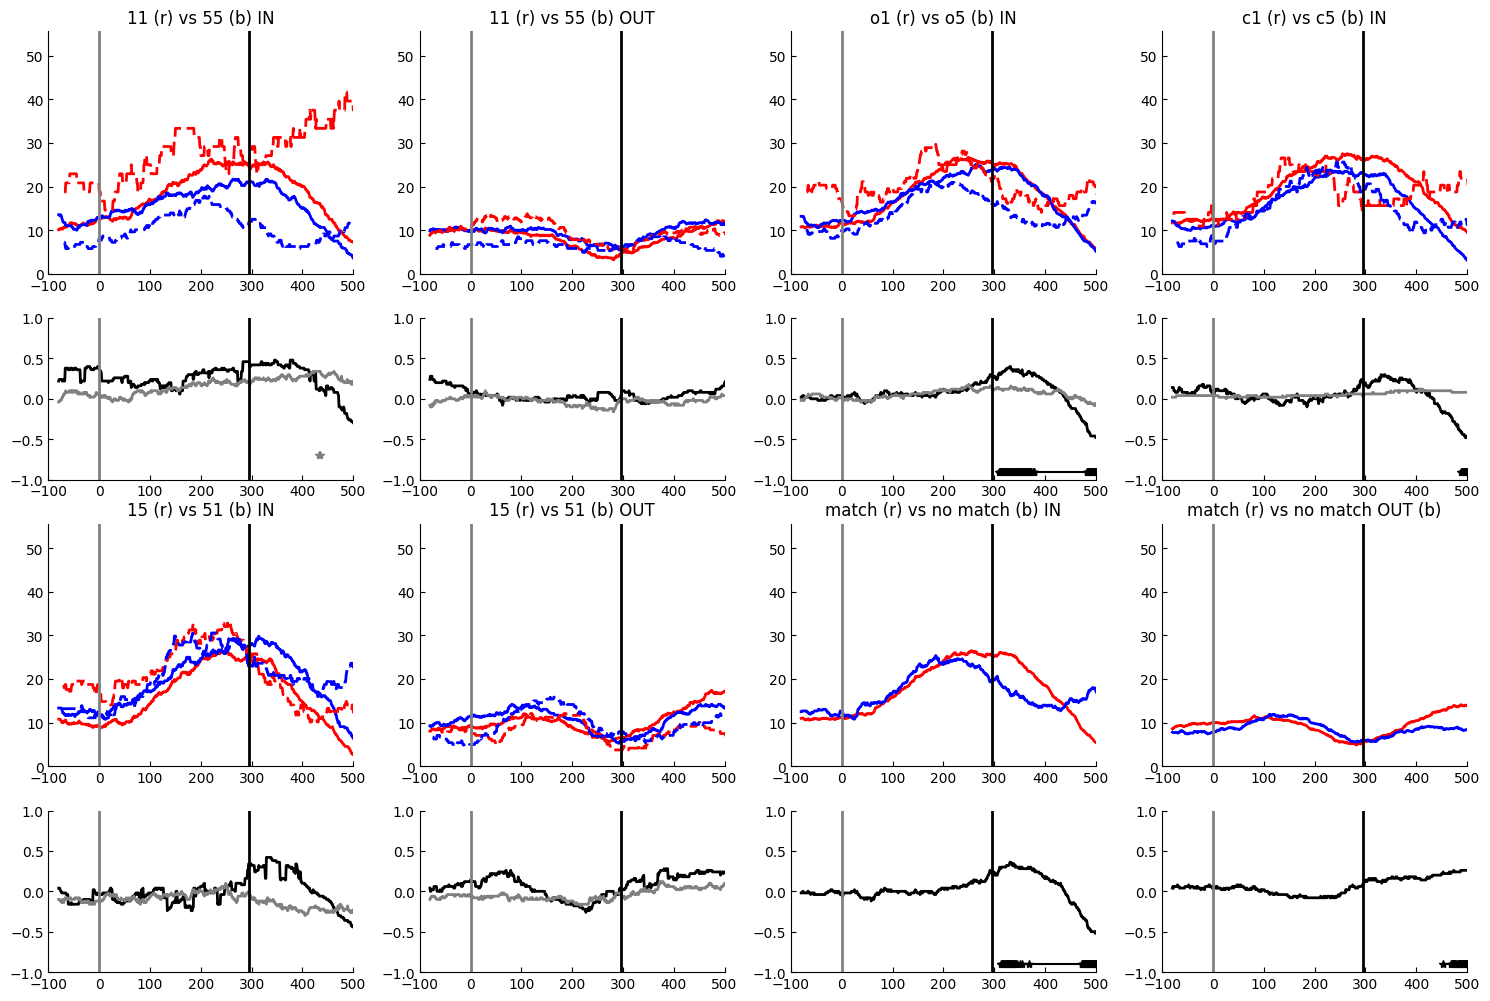

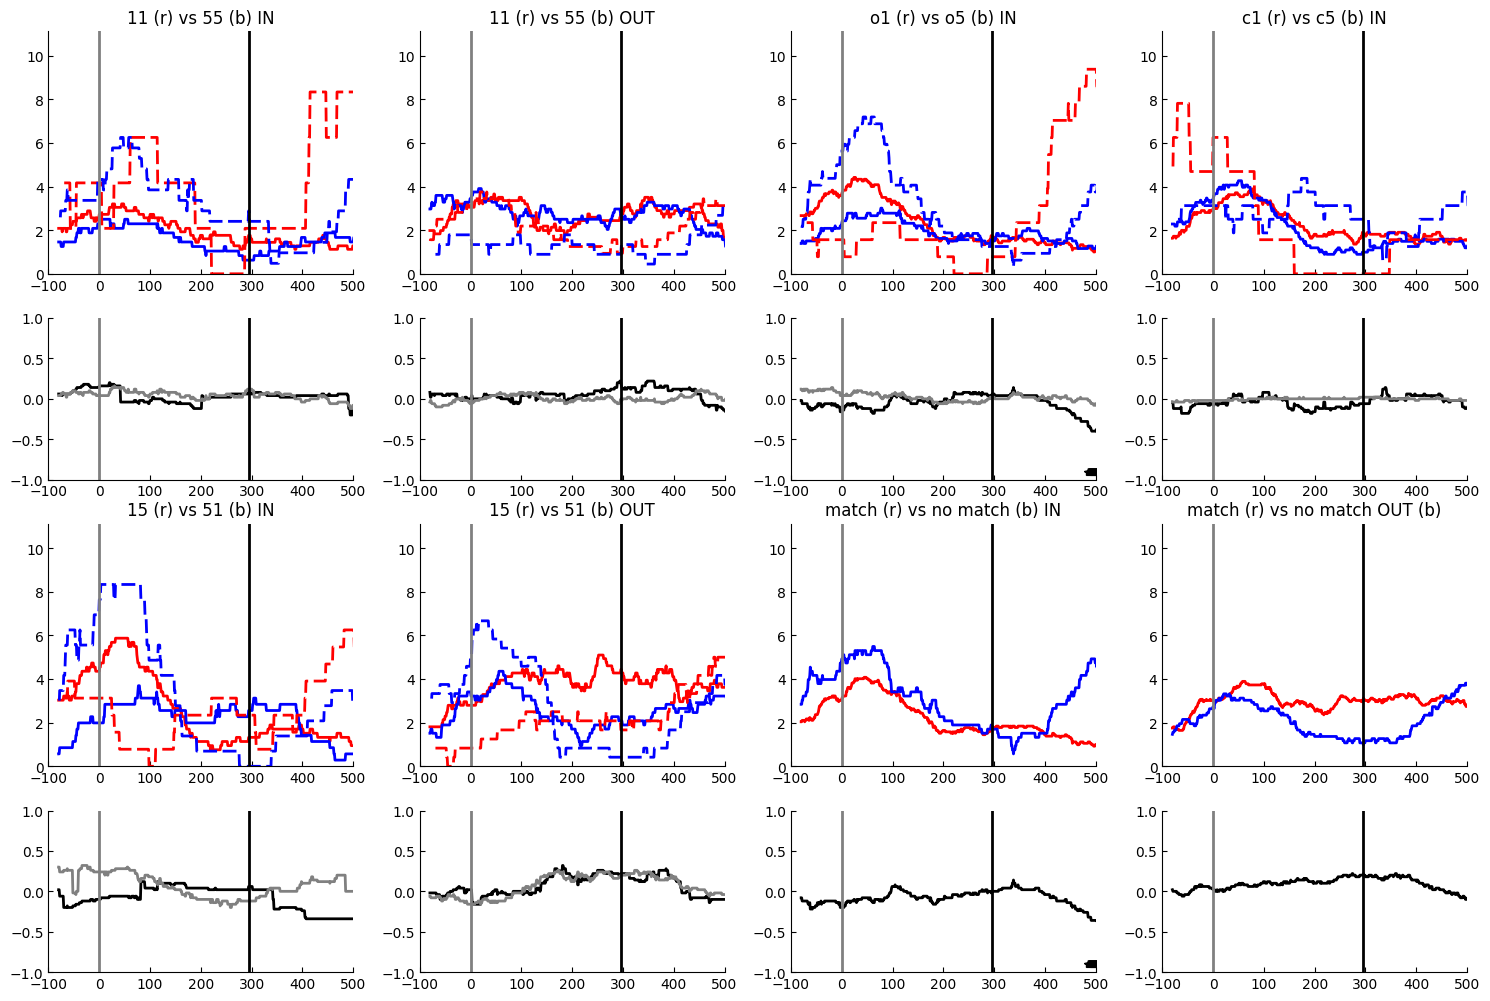

In [9]:



numcells=2#len(test_lip_avg)
plt.ioff()
# ocm_result    =   Parallel(n_jobs = -1)(delayed(ocm)(cell) for cell in tqdm(test_lip_avg[:numcells]))
ocm_result=[]
for cell in tqdm(test_lip_avg[:numcells]):
    r=ocm(cell)
    ocm_result.append(r)
lip_ocm_data    =reorganize_data(ocm_result)


with open('/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/averaged_structures/lip_roc_test', "wb") as fp: 
    pickle.dump(lip_ocm_data, fp)

['2022-12-01_good_1', '2022-12-01_good_2']

In [42]:
numcells=len(test_pfc_avg)
ocm_result    =   Parallel(n_jobs = -1)(delayed(ocm)(cell) for cell in tqdm(test_pfc_avg[:numcells]))
pfc_ocm_data    =reorganize_data(ocm_result)

with open('/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/averaged_structures/pfc_roc_test', "wb") as fp: 
    pickle.dump(pfc_ocm_data, fp)

KeyError: 'roc v match'

In [46]:
numcells=len(test_v4_avg)
ocm_result    =   Parallel(n_jobs = -1)(delayed(ocm)(cell) for cell in tqdm(test_v4_avg[:numcells]))
v4_ocm_data    =reorganize_data(ocm_result)

with open('/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/averaged_structures/v4_roc_test', "wb") as fp: 
    pickle.dump(v4_ocm_data, fp)